In [10]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 300

# Simple Categorical Model

## Building the ODE

This simple categorical model is a slightly modified SIR model. The main difference is that while the compartments represent concentrations, they do not sum to a constant value. Rather than mass or something analagous passing from one compartment to the next, a kind of "energy" or "life-force" passes from sugar to yeast to byproducts. The ODE is given by

$$\begin{align*}
    \dot{S} &= -\alpha \cdot S(t) \cdot Y(t) \\
    \dot{Y} &= \beta \cdot S(t) \cdot Y(t) - \gamma \cdot Y(t) \\
    \dot{C} &= \delta \cdot S(t) \cdot Y(t)
\end{align*}$$

Note that $\alpha$ is not necessarily equal to $\beta$ because the amount of sugar consumed by yeast is related though not equal to the biomass added to the yeast, and the rate at which yeast consumes sugar is not comparable to the rate at which yeast reproduces.

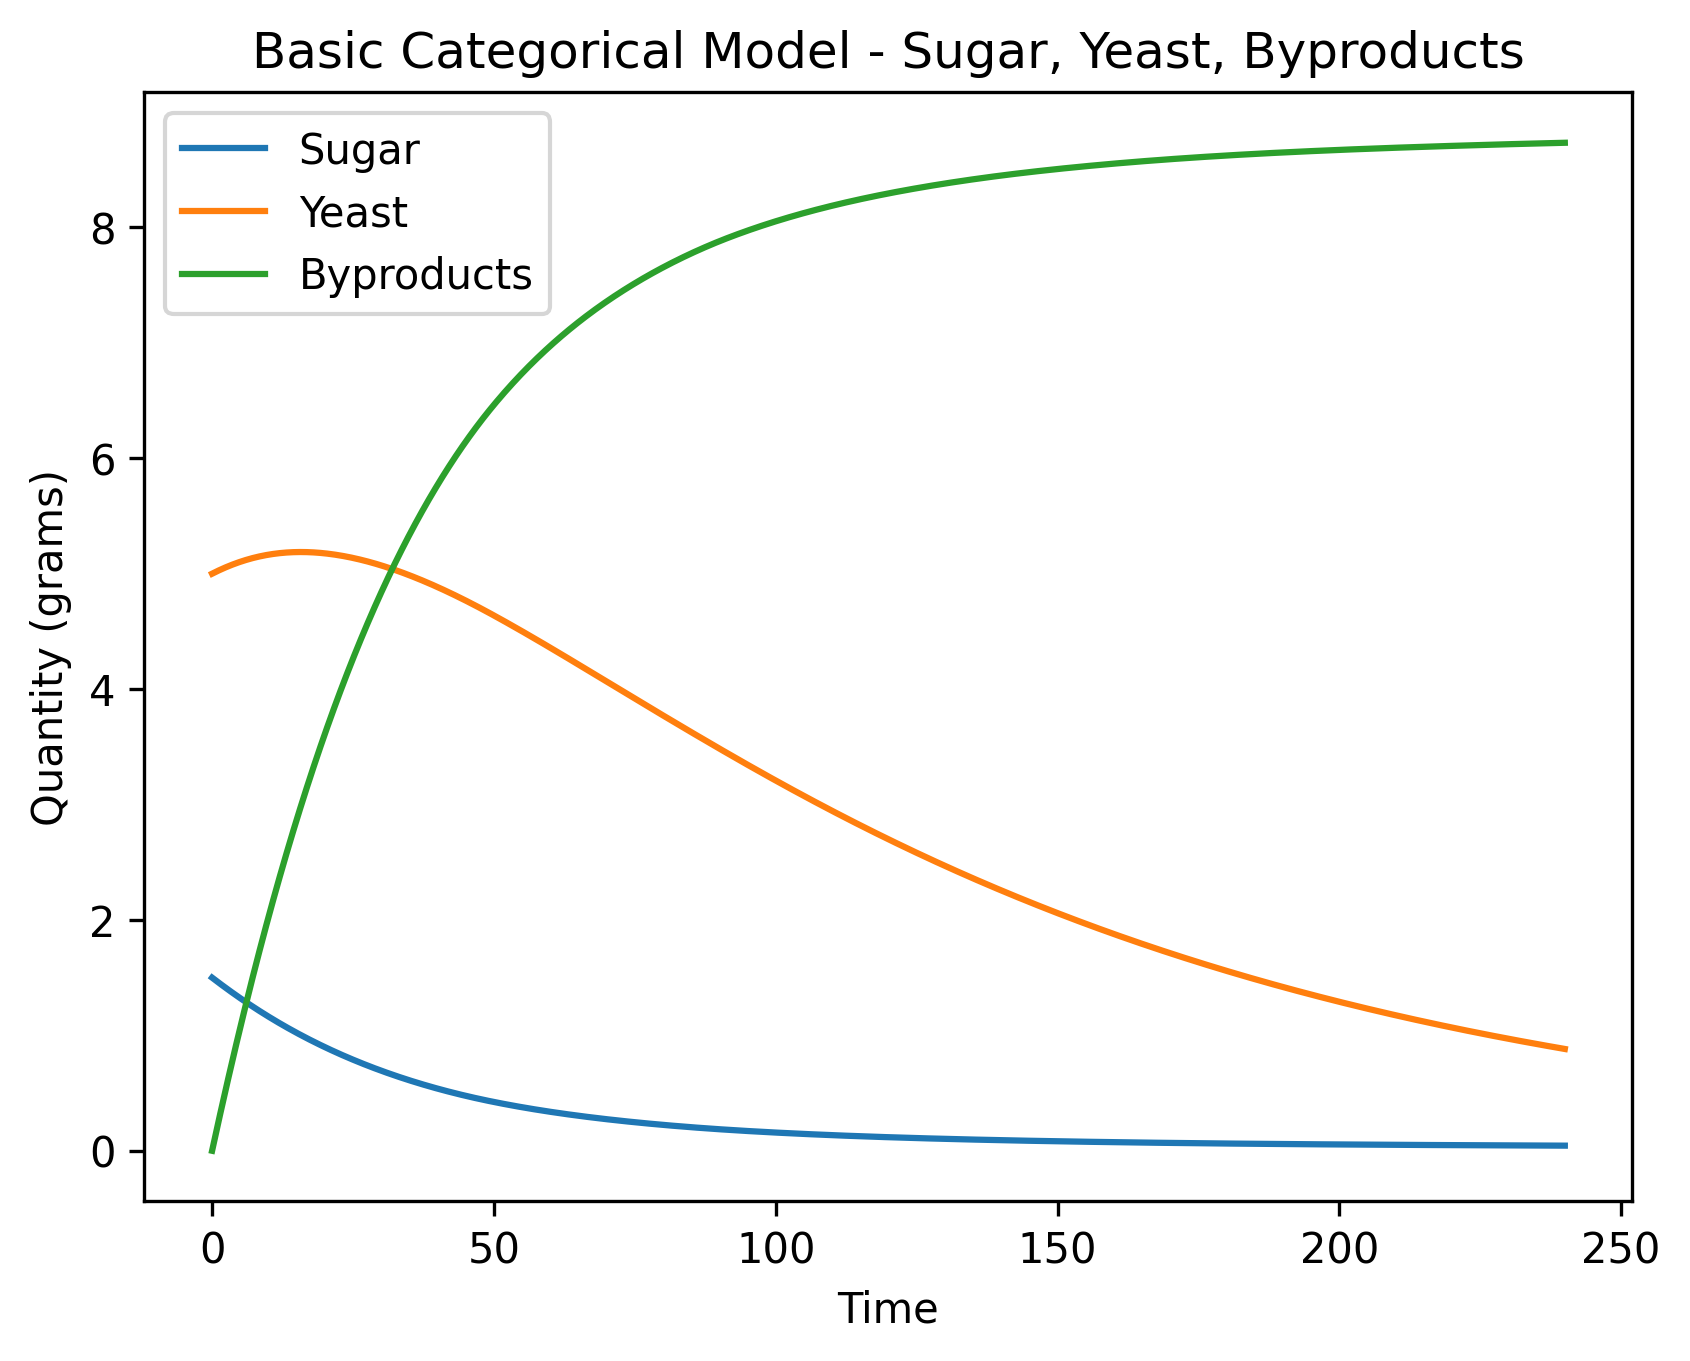

In [11]:
# Building the ODE
def ode(t, y, alpha, beta, gamma, delta):
    """
    Returns the ODE of our simple model.
    Assuming 3 categories; sugar, yeast, and byproducts, including CO2 and ethanol.
    Alpha controls sugar consumption. Beta controls reproduction rate of yeast. Gamma controls rate at which yeast cells die. Delta controls the production of byproducts.
    """
    return np.array([-alpha * y[0] * y[1], beta * y[0] * y[1] - gamma * y[1], delta * y[0] * y[1]])

# Building inputs
t0 = 0
tf = 4 * 60
t_span = (t0, tf)
y0 = np.array([1.5, 5, 0])  # Measured roughly in grams. Assuming 500 grams of flour
t = np.linspace(t0, tf, 1000)

# Parameters
alpha, beta, gamma, delta = 0.005, 0.01, 0.01, 0.03

sol = solve_ivp(ode, t_span, y0, t_eval=t,
                args=(alpha, beta, gamma, delta))

# Plotting the results
plt.plot(sol.t, sol.y[0], label="Sugar")
plt.plot(sol.t, sol.y[1], label="Yeast")
plt.plot(sol.t, sol.y[2], label="Byproducts")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Quantity (grams)")
plt.ylabel("Quantity (grams)")
plt.title("Basic Categorical Model - Sugar, Yeast, Byproducts")
plt.show()

## Fitting to real-world data

We fit this model to real-world data from a paper that worked with similar models. Surprisingly, the results matched the real data quite accurately.

The data used in this model comes from a study at the link here: https://www.mdpi.com/1099-4300/25/3/497.

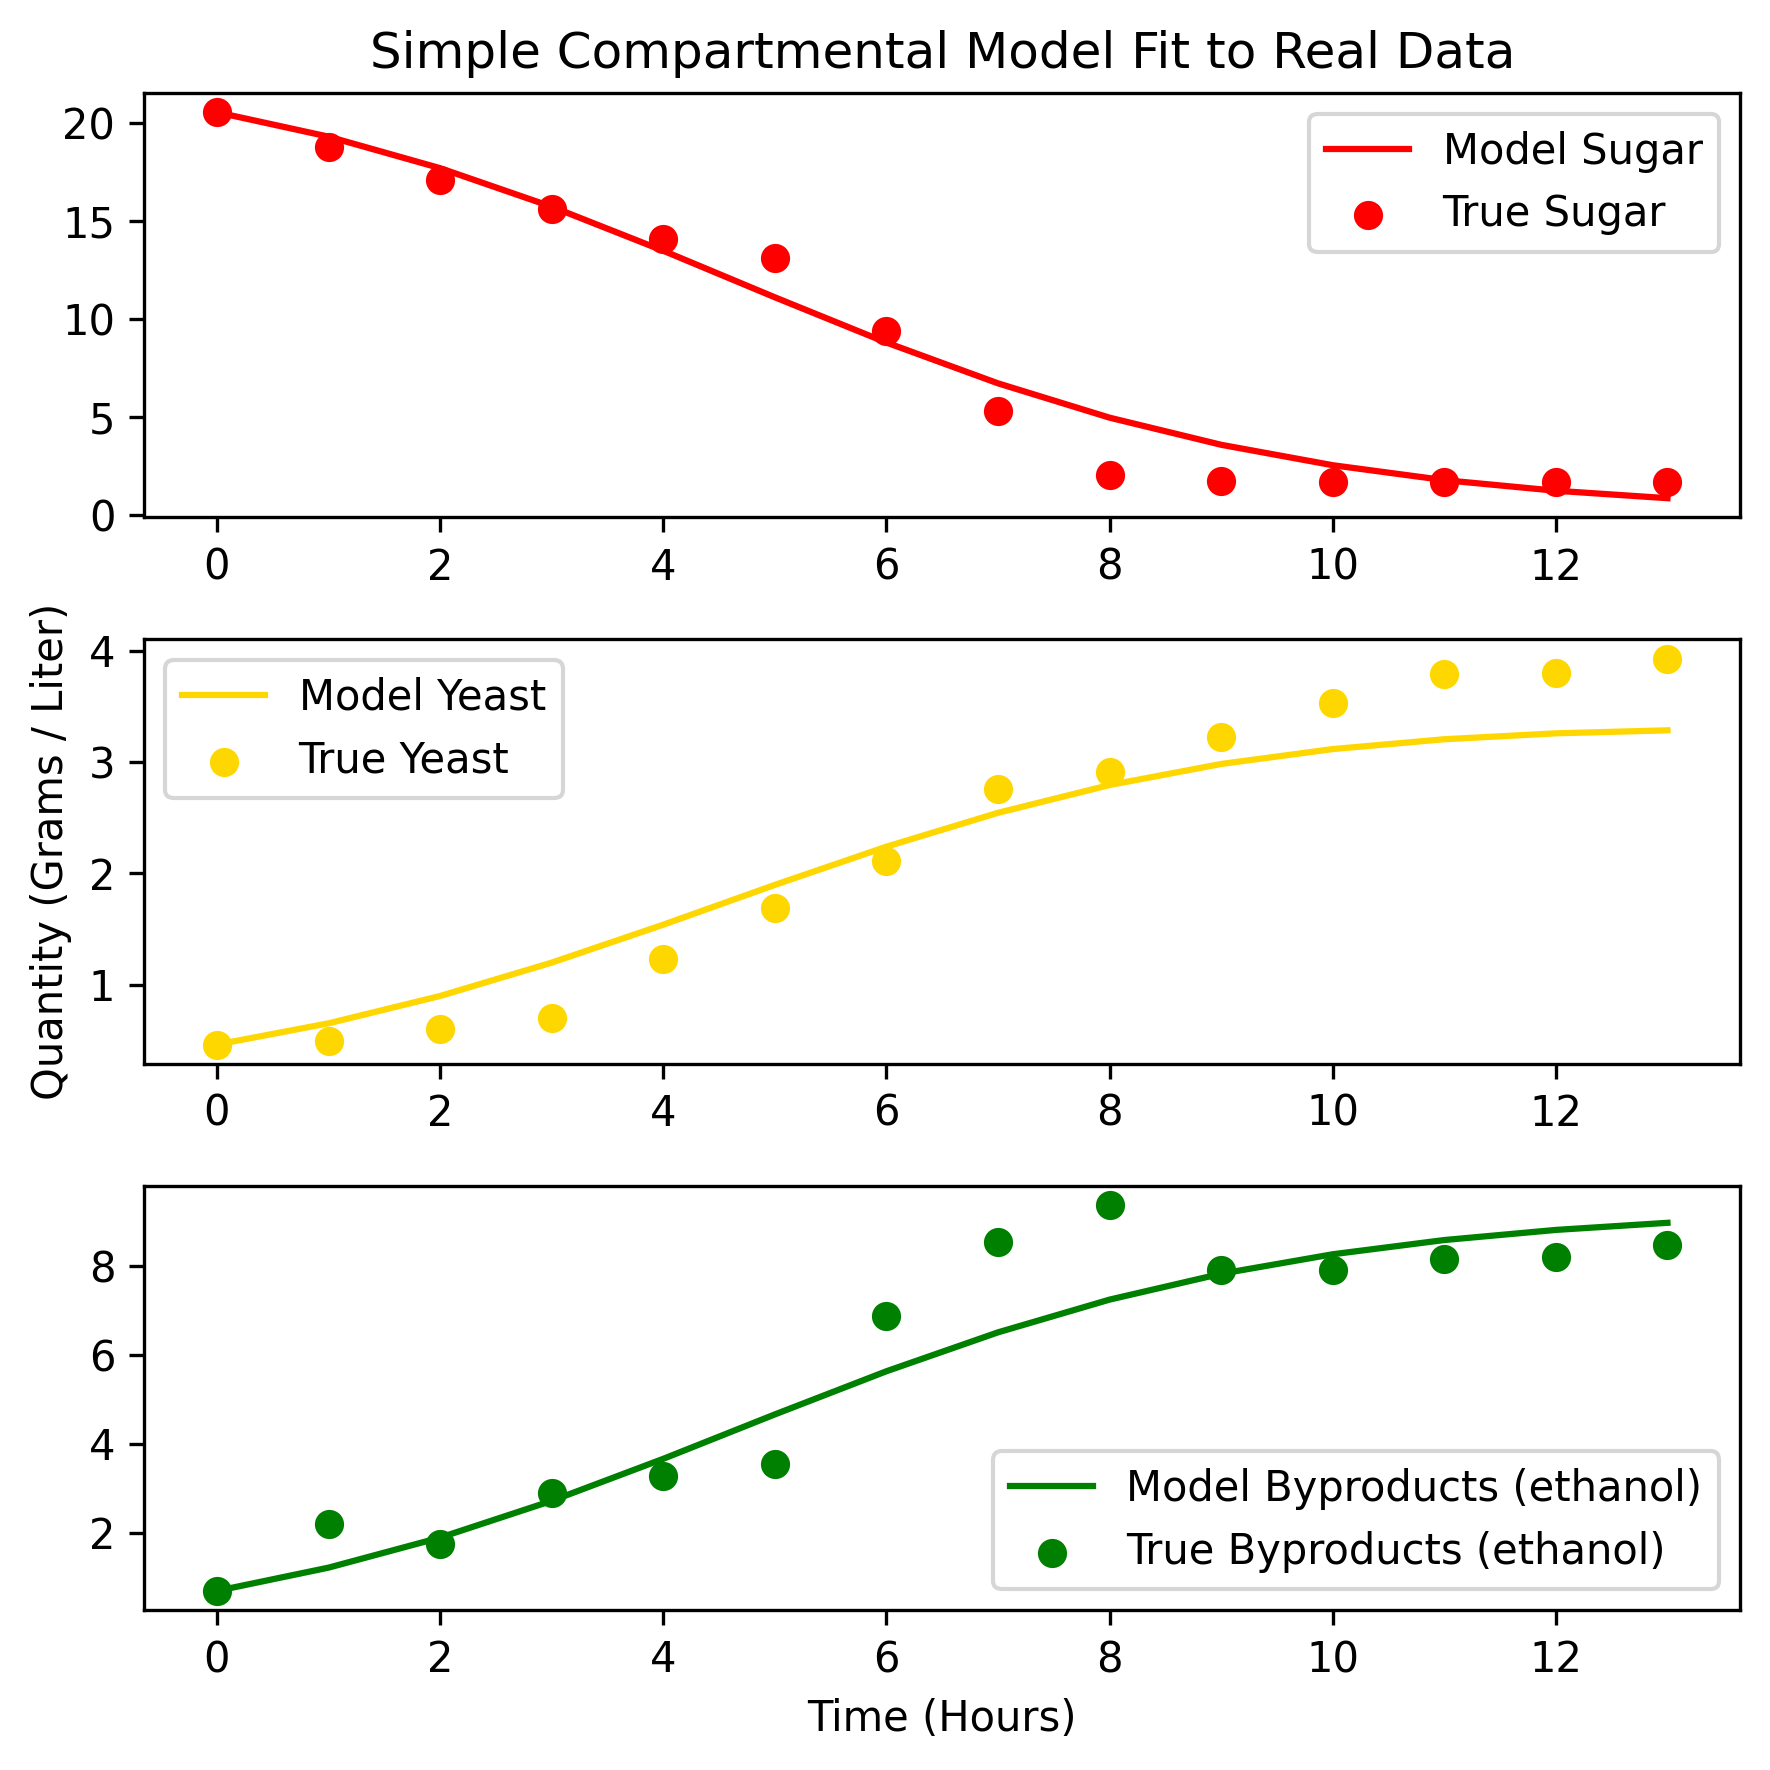

In [12]:
# Reading in data
sugar = pd.read_csv("data/sugar_strain1.csv").values[:, 1]
yeast = pd.read_csv("data/yeast_strain1.csv").values[:, 1]
byprod = pd.read_csv("data/ethanol_strain1.csv").values[:, 1]
true_vals = np.vstack([sugar, yeast, byprod])

# Making the error function
def calculate_error(params):
    """
    Computing the error of the ODE given its parameters
    """
    # Unpacking parameters
    alpha, beta, gamma, delta = params

    # Building the ODE
    def ode(t, y):
        return np.array([-alpha * y[0] * y[1], beta * y[0] * y[1] - gamma * y[1], delta * y[0] * y[1]])
    
    # Building time interval and initial conditions
    t0 = 0
    tf = 13
    t_span = (t0, tf)
    t_eval = np.linspace(t0, tf, 14)
    y0 = np.array([sugar[0], yeast[0], byprod[0]])

    sol = solve_ivp(ode, t_span, y0, t_eval=t_eval)

    # Computing the error using the Frobenius norm
    return np.linalg.norm(sol.y - true_vals, ord='fro')

# A guess for the parameters
p0 = (0.01, 0.01, 0.01, 0.01)
result = minimize(calculate_error, p0)
alpha, beta, gammal, delta = result.x

# Computing what our model estimates the result should be
def ode(t, y):
    return np.array([-alpha * y[0] * y[1], beta * y[0] * y[1] - gamma * y[1], delta * y[0] * y[1]])
    
# Building time interval and initial conditions
t0 = 0
tf = 13
t_span = (t0, tf)
t_eval = np.linspace(t0, tf, 14)
y0 = np.array([sugar[0], yeast[0], byprod[0]])

sol = solve_ivp(ode, t_span, y0, t_eval=t_eval)

# Graphing the result
plt.figure(figsize=(6, 6))
plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0], color='r', label="Model Sugar")
plt.scatter(t_eval, sugar, color='r', label="True Sugar")
plt.legend()
plt.title("Simple Compartmental Model Fit to Real Data")

plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[1], color='gold', label="Model Yeast")
plt.scatter(t_eval, yeast, color='gold', label="True Yeast")
plt.ylabel("Quantity (Grams / Liter)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sol.t, sol.y[2], color='g', label="Model Byproducts (ethanol)")
plt.scatter(t_eval, byprod, color='g', label="True Byproducts (ethanol)")
plt.legend()
plt.xlabel("Time (Hours)")
plt.tight_layout()
plt.show()

In [13]:
# Final fit parameters
print(f"alpha: {alpha}\nbeta: {beta}\ngamma: {gamma}\ndelta: {delta}")

alpha: 0.1127983210116926
beta: 0.017788187881001945
gamma: 0.01
delta: 0.04748943834320091


# Monod Categorical

This model is a more sophisticated twist on the prior simple compartmental model in that it leverages an insight from the biologist Monod.

$$\begin{align*}
    \dot{Y} &= \mu_{\text{max}} \frac{S}{K_s + S}Y \\
    \dot{S} &= -\frac{1}{Y_{X/S}} \dot{Y} \\
    \dot{P} &= Y_{P/S} (-\dot{S})
\end{align*}$$

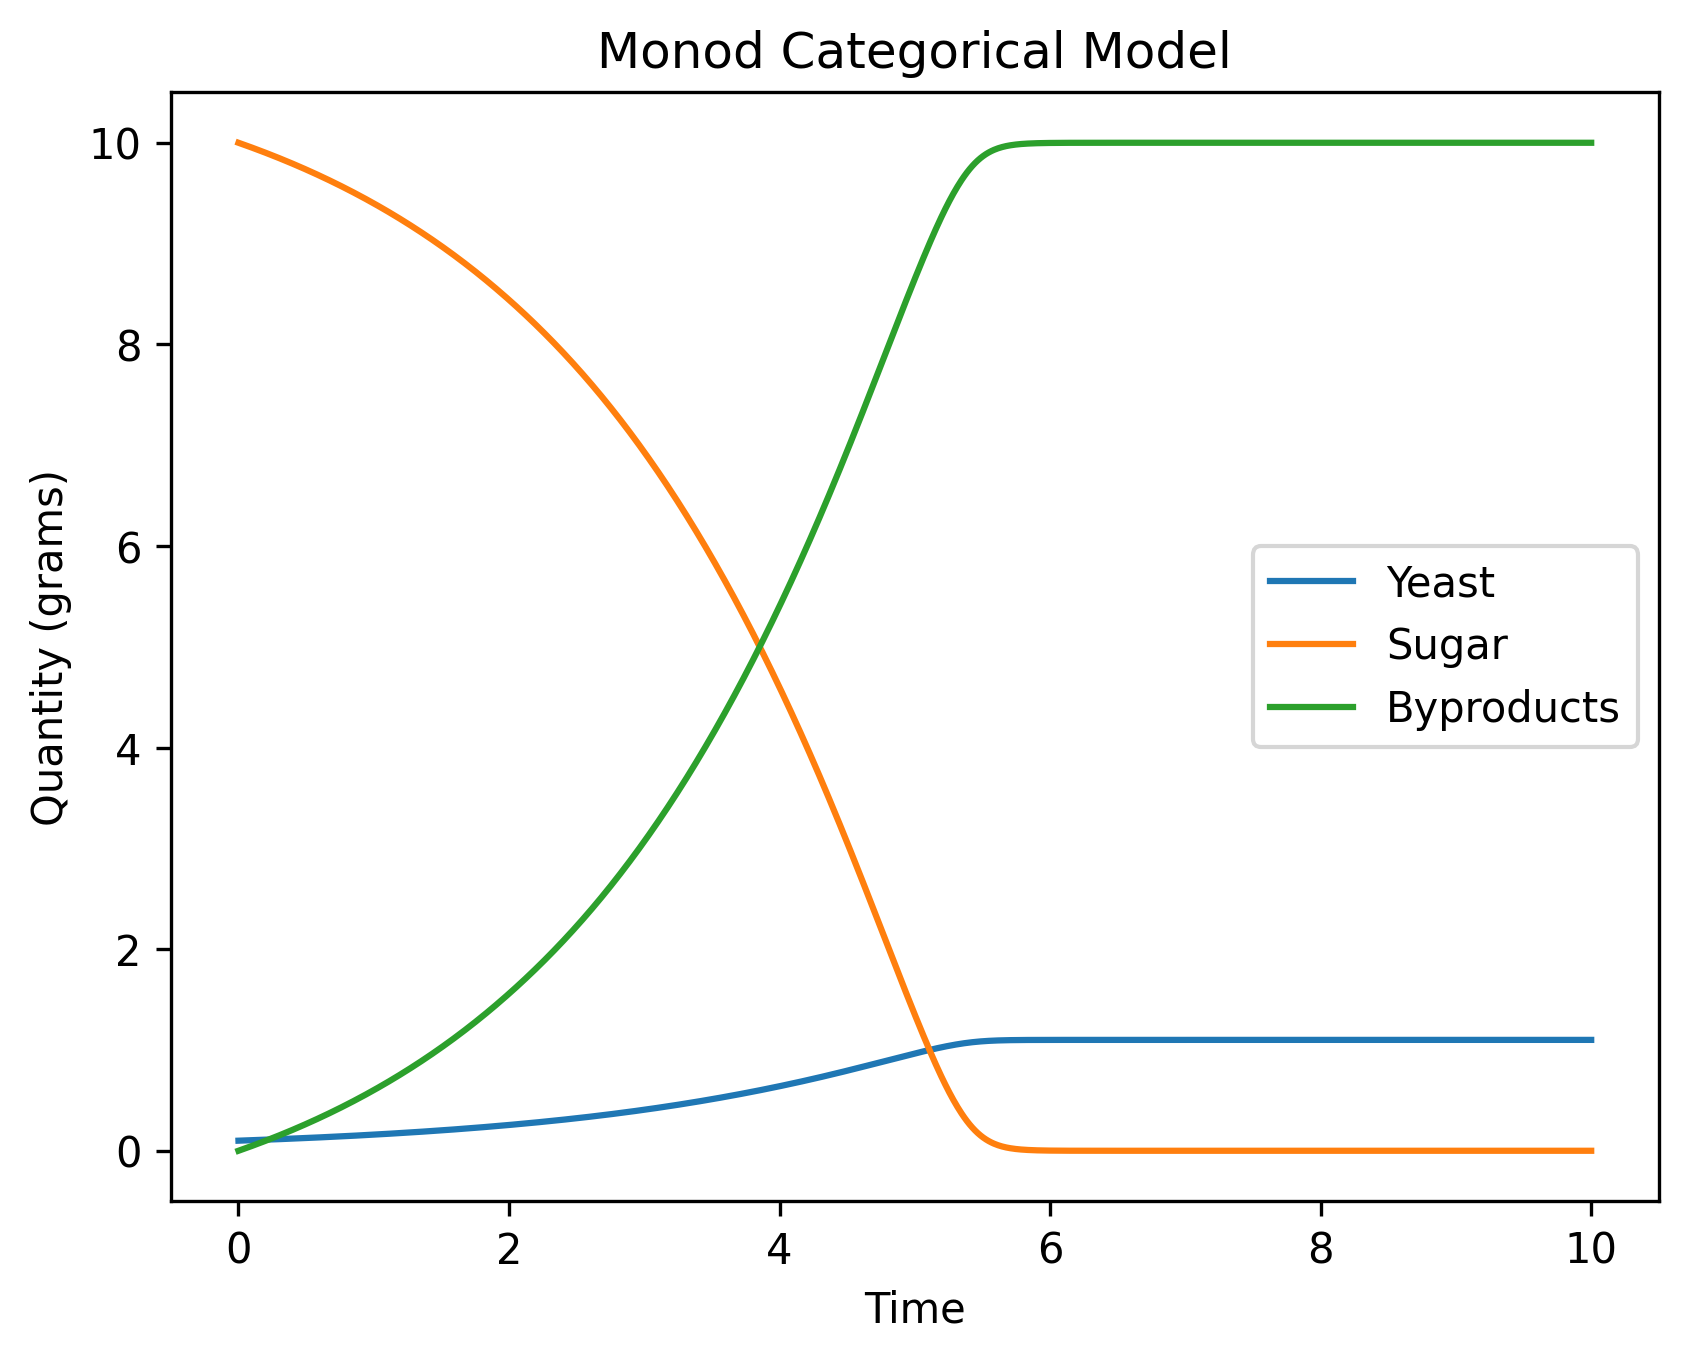

In [ ]:
def ode(t, y, mu_max, K, Yxs, Yps):
    """Categorical model for yeast growth with three categories: yeast, sugar, and byproducts.
    Uses the monod equation for yeast growth.
    """
    return np.array([
        mu_max * (y[1] / (K + y[1])) * y[0],
        -(1 / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0],
        (Yps / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0]
    ])

# Building inputs
t0 = 0
tf = 10
t_span = (t0, tf)
y0 = np.array([0.1, 10, 0])  # g/L
t = np.linspace(t0, tf, 1000)

# Parameters
mu_max = 0.5  # Maximum growth rate of yeast
K = 0.6    # Half-velocity constant
Yxs = 0.1  # Biomass per g sugar
Yps = 1  # Product yield

sol = solve_ivp(ode, t_span, y0, t_eval=t,
                args=(mu_max, K, Yxs, Yps))

# Plotting the results
plt.plot(sol.t, sol.y[0], label="Yeast")
plt.plot(sol.t, sol.y[1], label="Sugar")
plt.plot(sol.t, sol.y[2], label="Byproducts")

plt.xlabel("Time")
plt.ylabel("Quantity (grams)")
plt.title("Monod Categorical Model")
plt.legend()

plt.show()

# KM Mechanistic Model

This model comes from a paper at the following source: https://www.mdpi.com/1099-4300/25/3/497.

$$\begin{align*}
    \dot{X} &= \frac{\rho_1XY}{\rho_2 + Y} - \rho_3XY -\rho_4X \\
    \dot{Y} &= -\rho_5XY - \rho_6YZ - \rho_7Y \\
    \dot{Z} &= \rho_8XZ + \rho_9YZ - \rho_{10}Z
\end{align*}$$

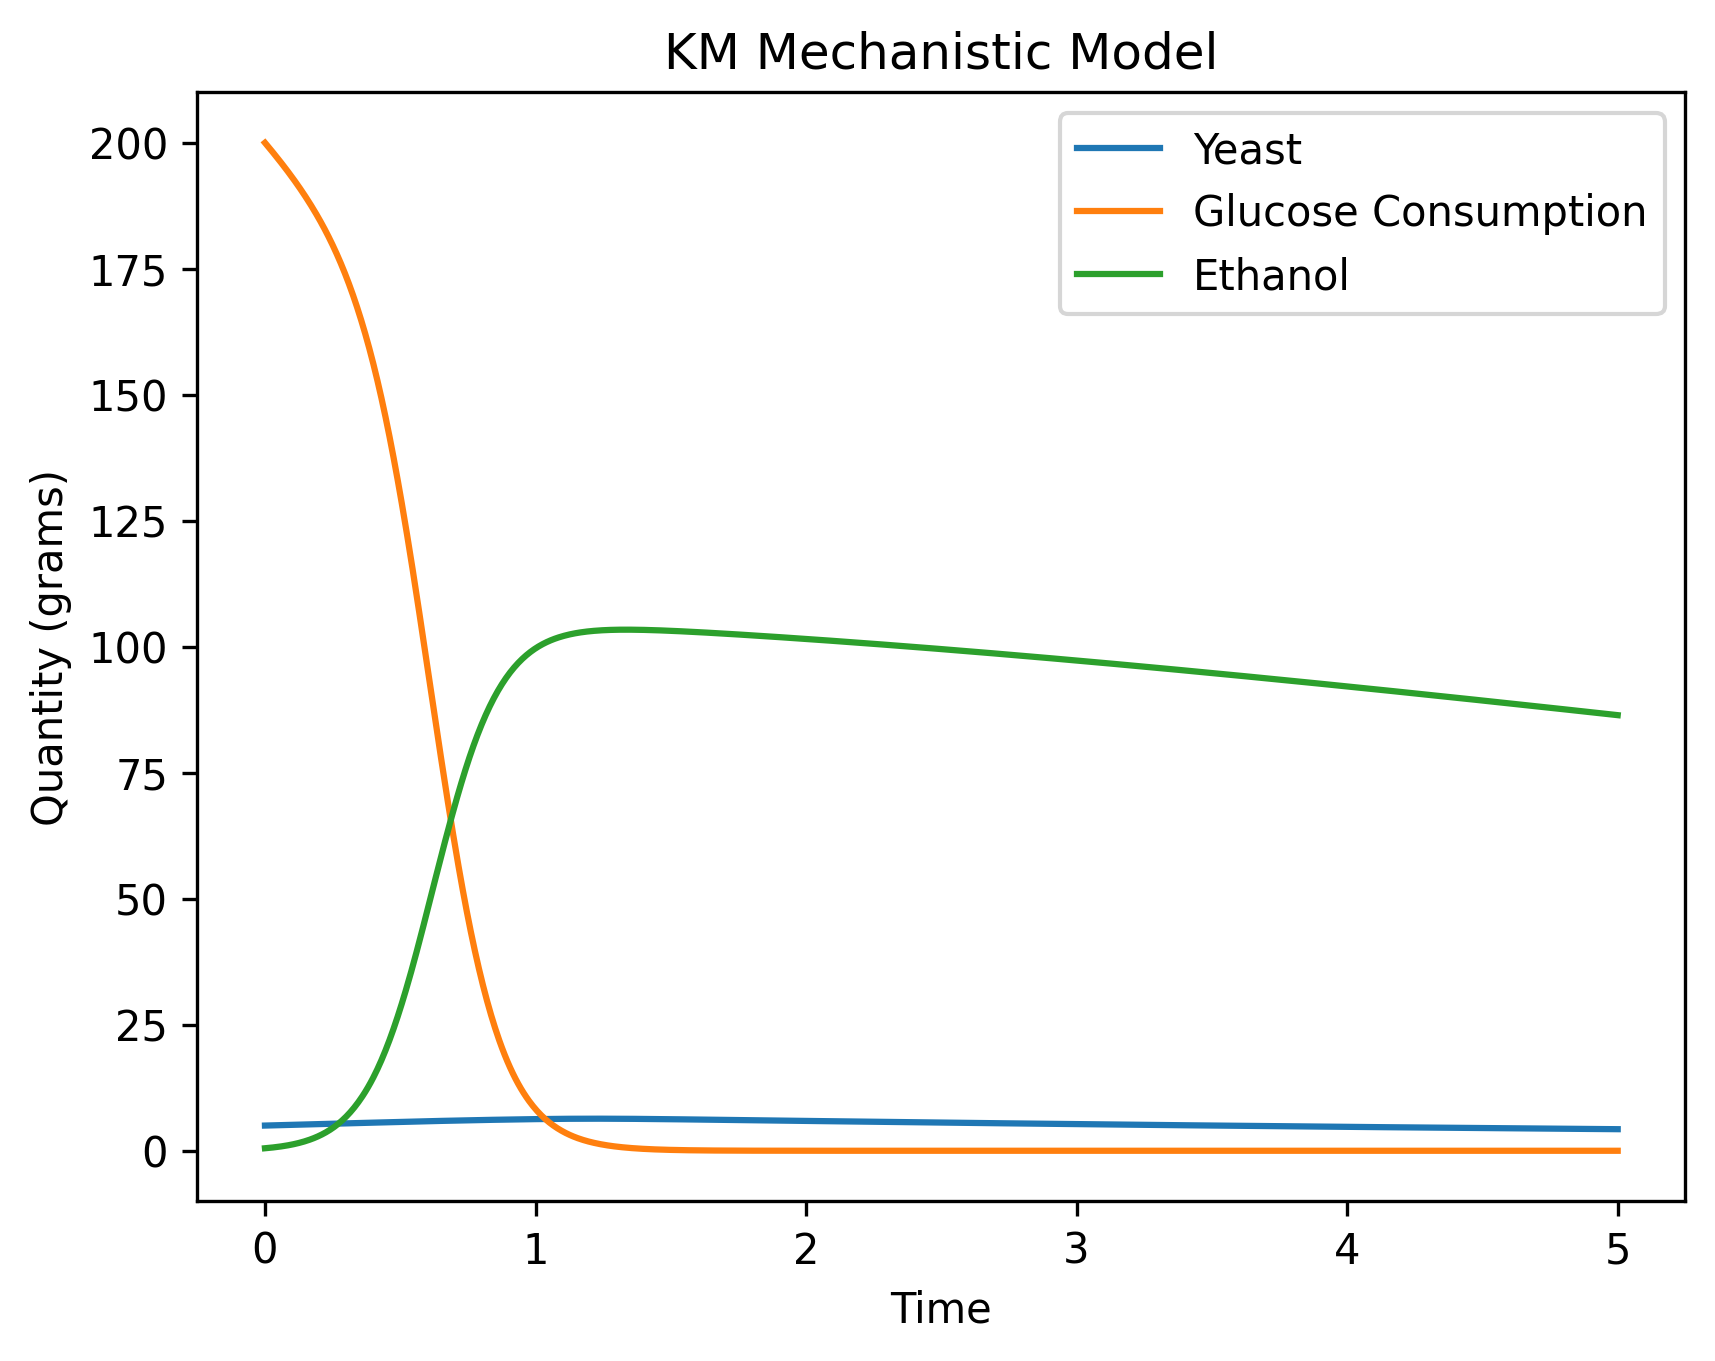

In [ ]:
# Building the ODE from the paper
def ode(t, u, rho):
    """KM model from paper."""
    r1, r2, r3, r4, r5, r6, r7, r8, r9, r10 = rho
    x, y, z, = u
    return np.array([
        ((r1*x*y) / (r2+y)) - r3*x*z - r4*x,
        -r5*x*y - r6*y*z - r7*y,
        r8*x*z + r9*y*z - r10*z
    ])

# Building inputs
t0 = 0
tf = 5
t_span = (t0, tf)
u0 = np.array([5, 200, 0.5])  # g/L
t = np.linspace(t0, tf, 1000)

# Parameters
r1 = 289.385e-3
r2 = 2.281
r3 = 1.066e-3
r4 = 7.275e-3
r5 = 56.893e-3
r6 = 71.842e-3
r7 = 824.233e-9
r8 = 19.088e-3
r9 = 46.352e-3
r10 = 149.899e-3
rho = [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10]

# Solving the IVP
sol = solve_ivp(ode, t_span, u0, t_eval=t,
                args=(rho,))

# Plotting each of the categories
plt.plot(sol.t, sol.y[0], label="Yeast")
plt.plot(sol.t, sol.y[1], label="Glucose Consumption")
plt.plot(sol.t, sol.y[2], label="Ethanol")

plt.xlabel("Time")
plt.ylabel("Quantity (grams)")
plt.title("KM Mechanistic Model")
plt.legend()

plt.show()

# Fitting the Monod Categorical Model to Real World Data

In [ ]:
# Reading in the data. This data comes from the paper at: https://www.mdpi.com/1099-4300/25/3/497
yeast = pd.read_csv("data/yeast_strain1.csv").values[:, 1]
sugar = pd.read_csv("data/sugar_strain1.csv").values[:, 1]
byprod = pd.read_csv("data/ethanol_strain1.csv").values[:, 1]
true_vals = np.vstack([yeast, sugar, byprod])

# Error function to fit parameters
def calculate_error(params):
    mu_max, K, Yxs, Yps = params

    # The ODE for this model
    def ode(t, y, mu_max, K, Yxs, Yps):
        """Categorical model for yeast growth with three categories: yeast, sugar, and byproducts.
        Uses the monod equation for yeast growth.
        """
        return np.array([
            mu_max * (y[1] / (K + y[1])) * y[0],
            -(1 / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0],
            (Yps / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0]
        ])
    
    # Building inputs
    t0 = 0
    tf = 13
    t_span = (t0, tf)
    t_eval = np.linspace(t0, tf, 14)
    y0 = np.array([yeast[0], sugar[0], byprod[0]])

    # Using solve_ivp to compute the result
    sol = solve_ivp(ode, t_span, y0, t_eval=t_eval, 
                    args=(mu_max, K, Yxs, Yps))

    return np.max(np.linalg.norm(sol.y - true_vals, axis=0))

# Initial guess for parameters
p0 = (0.1, 0.1, 0.2, 0.7)
result = minimize(calculate_error, p0)
mu_max, K, Yxs, Yps = result.x

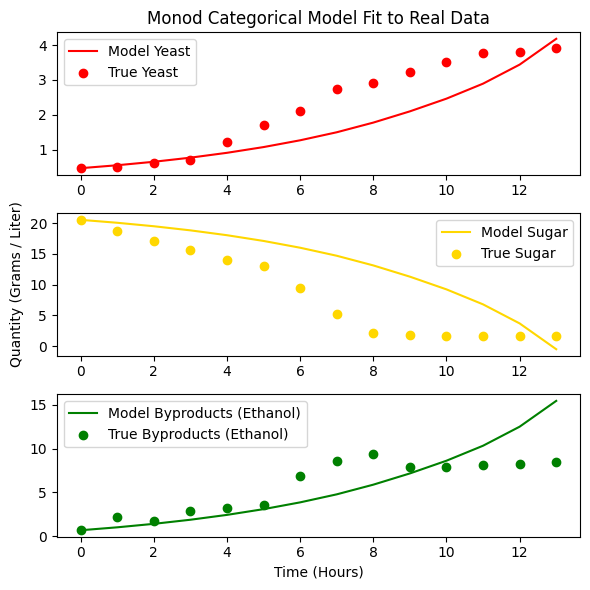

In [ ]:
# Building the ODE
def ode(t, y, mu_max, K, Yxs, Yps):
    """Categorical model for yeast growth with three categories: yeast, sugar, and byproducts.
    Uses the monod equation for yeast growth.
    """
    return np.array([
        mu_max * (y[1] / (K + y[1])) * y[0],
        -(1 / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0],
        (Yps / Yxs) * mu_max * (y[1] / (K + y[1])) * y[0]
    ])

# Building initial inputs
t0 = 0
tf = 13
t_span = (t0, tf)
t_eval = np.linspace(t0, tf, 14)
y0 = np.array([yeast[0], sugar[0], byprod[0]])

# Solving the ODE
sol = solve_ivp(ode, t_span, y0, t_eval=t_eval,
                args=(mu_max, K, Yxs, Yps))

# PLotting the results
plt.figure(figsize=(6, 6))
plt.subplot(3, 1, 1)
plt.plot(sol.t, sol.y[0], color='r', label="Model Yeast")
plt.scatter(t_eval, yeast, color='r', label="True Yeast")
plt.legend()
plt.title("Monod Categorical Model Fit to Real Data")

plt.subplot(3, 1, 2)
plt.plot(sol.t, sol.y[1], color='gold', label="Model Sugar")
plt.scatter(t_eval, sugar, color='gold', label="True Sugar")
plt.ylabel("Quantity (Grams / Liter)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(sol.t, sol.y[2], color='g', label="Model Byproducts (Ethanol)")
plt.scatter(t_eval, byprod, color='g', label="True Byproducts (Ethanol)")
plt.legend()
plt.xlabel("Time (Hours)")
plt.tight_layout()
plt.show()

# MacArthur Consumer Resource Model

This model is motivated by thinking of Yeast as a consumer with two different resources, namely sugar and oxygen, each of which it metabolizes differently--at different rates, with different levels of efficiency, and with different byproducts. In fact, yeast metabolizes sugar differently depending on the amount of oxygen available. We consider the change in concentration of yeast, oxygen, sugar, and carbon dioxide. I should cite sources here too.

## Equations
$$
\begin{align*}
    \dot{Y} &= Y \bigg[w_O c_O O + [w_S^{ana}​+(w_S^{aer}​−w_S^{ana}​)f(O)]c_S S - m\bigg] \\
    \dot{O} &= -c_O O Y f(O) \\
    \dot{S} &= r_S S (1 - \frac{S}{P_S}) - c_S Y S \\
\end{align*}

## Units and notes

**Populations**   
Everything is in concentrations.  
- $Y$ (yeast): $\frac{g_Y}{L}$ (dry yeast per liter of dough).  
- $O$ (oxygen): $\frac{mmol}{L}$ (millimoles of $O_2$ per liter of dough).  
- $S$ (sugar): $\frac{GGE}{L}$ (grams of glucose-equivalent per liter of dough).  
- $C$ (CO_2): $\frac{mol}{L}$

**Growth Parameters**
- $K_O$: $\frac{mmol}{L}$ Half saturation for Oxygen. Below this we get pretty anaerobic. Appears in $f(O)$ formula, matches $O$ units in denominator. 
- $K_S$: $\frac{GGE}{L}$ Half saturation for Sugar.
- $P_S$: $\frac{g_S}{L}$ Carrying capacity for sugar, or saturation or whatever.  
- $r_S$: $\frac{1}{h}$ Sugar logistic growth rate, how fast it appears.  
- $f(O)$: $\frac{mmol}{L}$ Monod equation with oxygen, oxygen availibility switch. Near 1 when oxygen is plentiful, near 0 when it's gone. Controls how efficient sugar metabolism is with $[w_S^{ana}​+(w_S^{aer}​−w_S^{ana}​)f(O)]$.  

**Yield**   
resource consumed $\rightarrow$ biomass added. 
- $w_S^{aer}$: $\frac{g_Y}{g_S}$ aerobic ATP yield, very efficient.  
- $w_S^{ana}$: $\frac{g_Y}{g_S}$ anaerobic ATP yield, inefficient.  
- $w_O$: $\frac{g_Y}{mmol}$ Oxygen yield.  
These are multiplied by the $c_SSY$ and $c_OOY$ terms--for how much resource disappears, how much consumer appears?

**Uptake**
- $c_S$: $\frac{L}{g_Yh}$ This is sugar uptake, how quickly yeast processes sugar per unit biomass. So $c_SSY$ is in GGE / Lh, or concentration of sugar per hour.  
- $c_O$: $\frac{L}{g_Yh}$ Oxygen uptake, how quickly yeast processes Oxygen per unit biomass. So $c_OOY$ is $\frac{mmol}{Lh}$.  

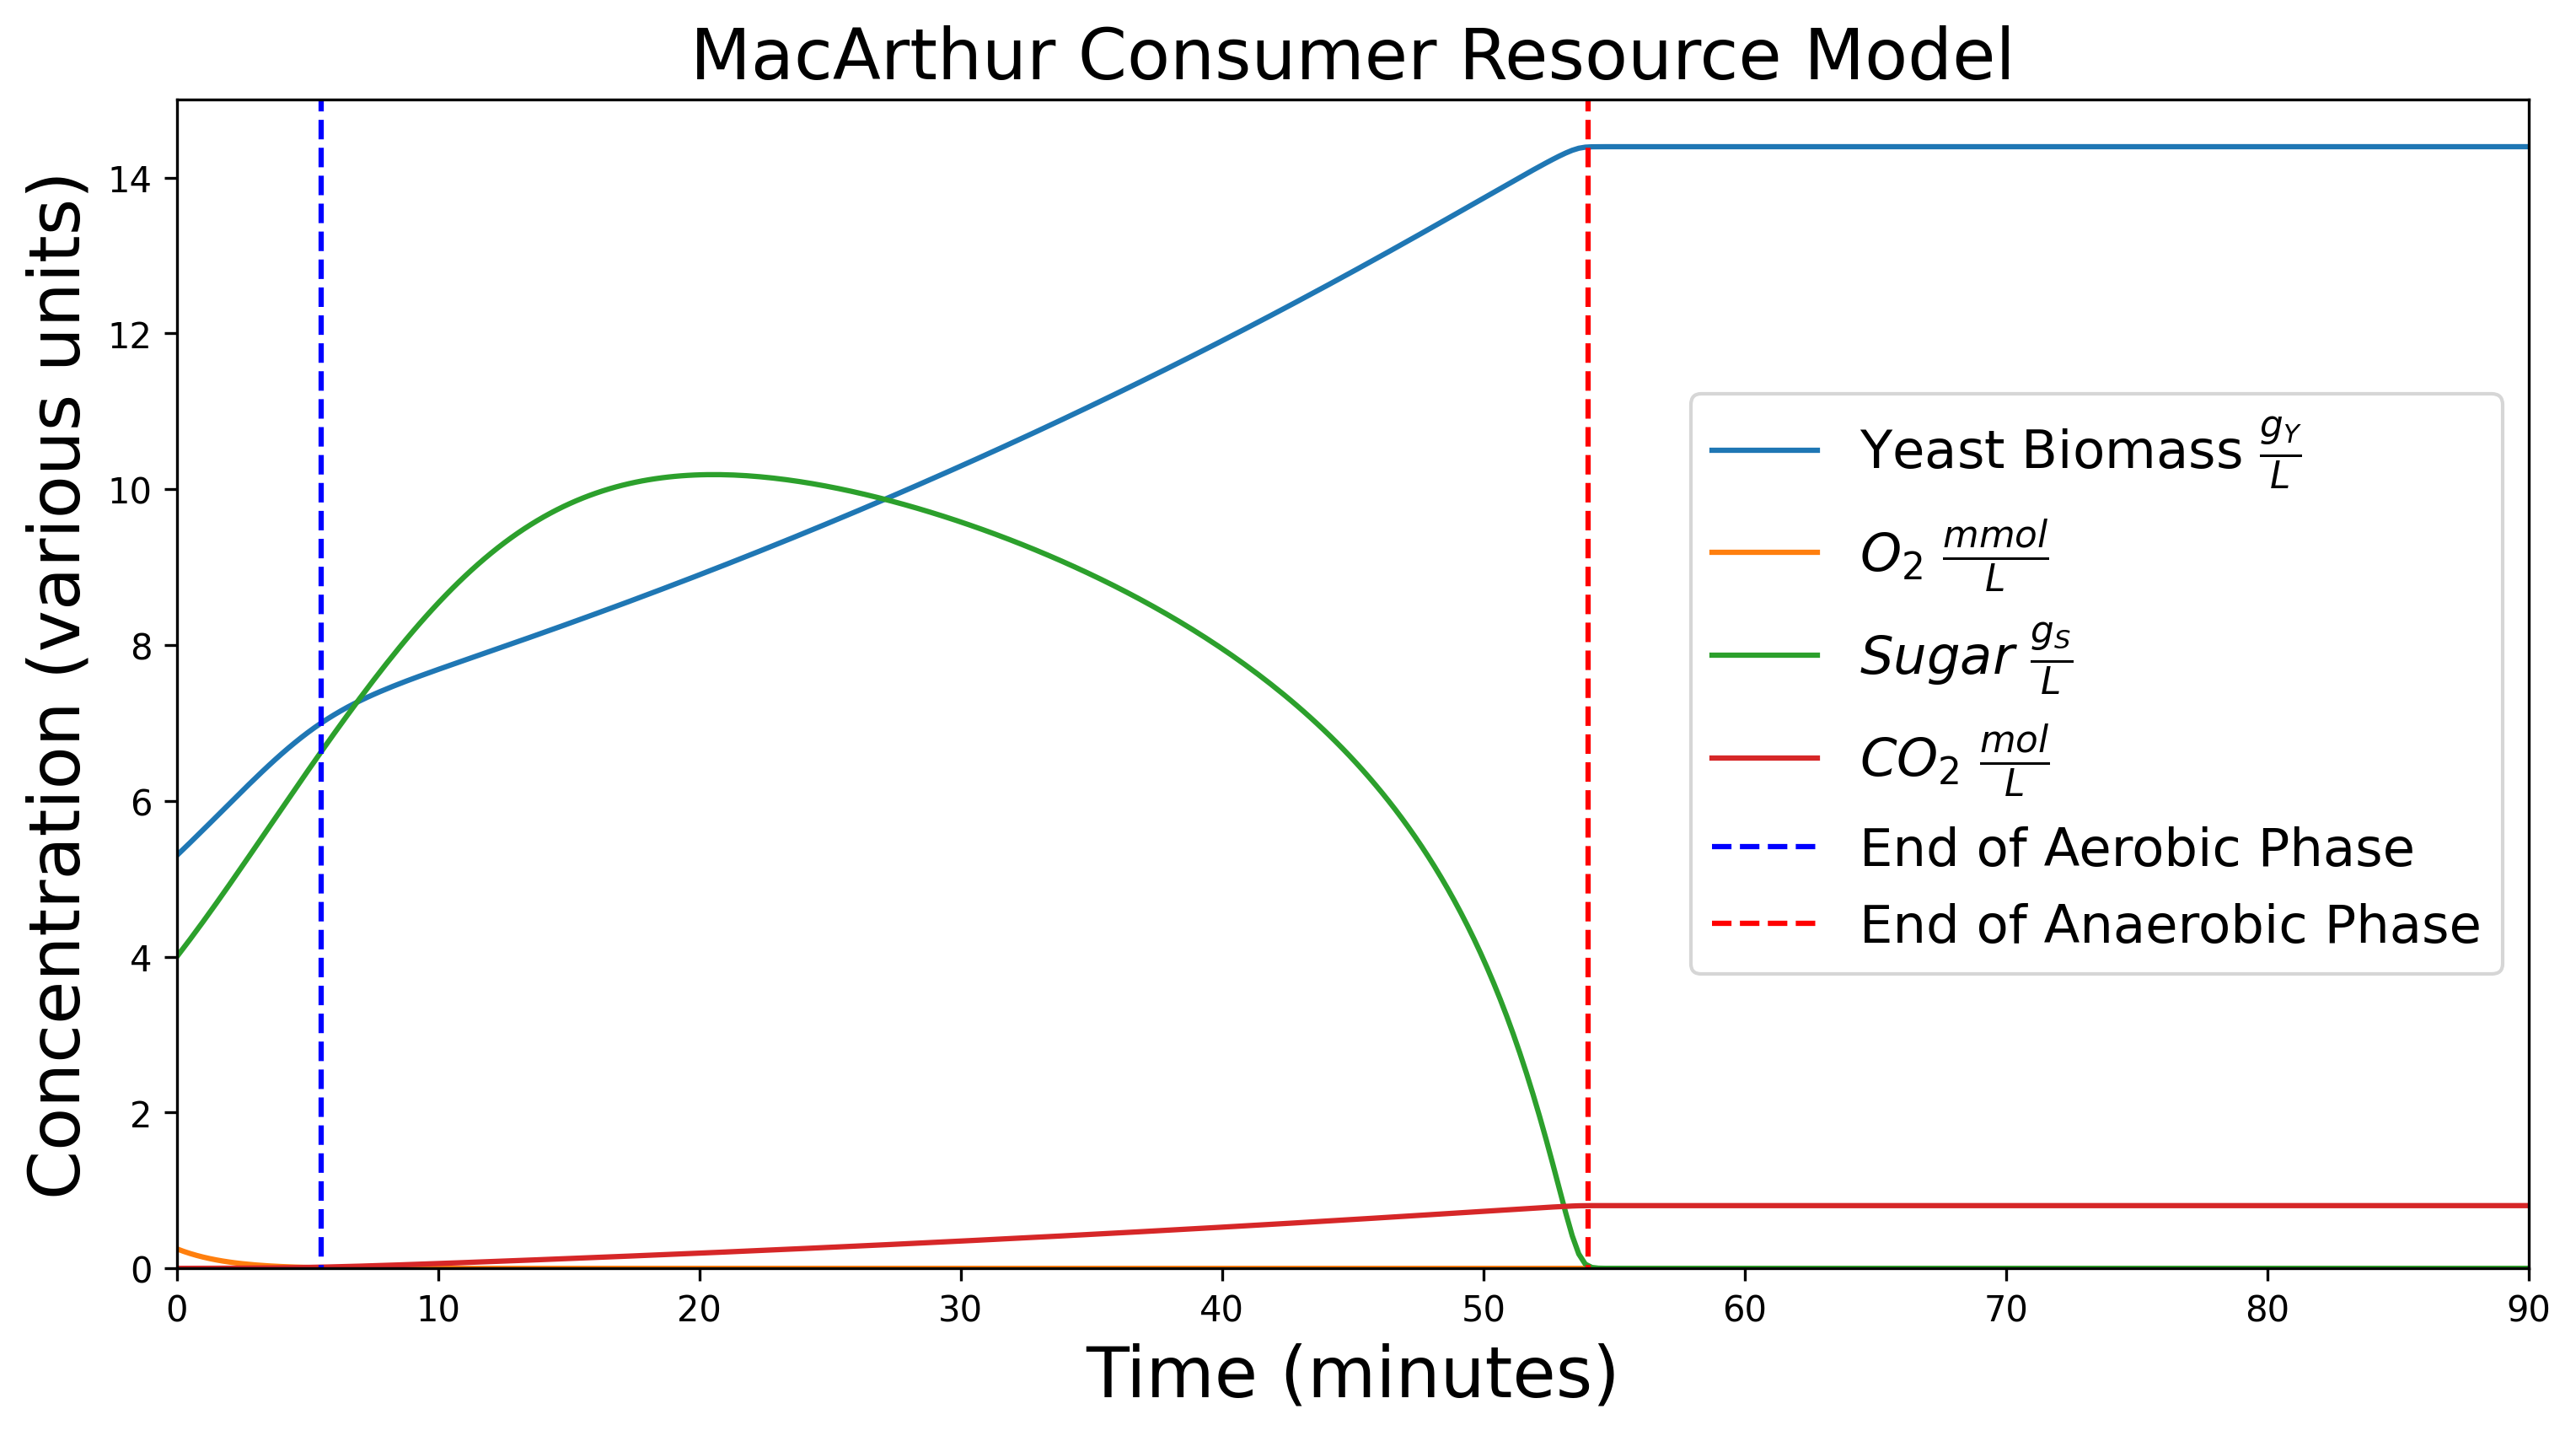

In [ ]:
def solve_and_graph(params, t0=0, tf=90, figsize=(12, 6), show_phases=True):
    """Given constants and initial values, solve and graph the MCRM ODE."""
    # Unpack parameters
    wo, waer, wana, ko, ks, ps, rs, co, cs, m, Y_0, O_0, S_0, C_0 = params

    def ode(t, yosc):
        "Define ode, to be passed into solve_ivp()"
        # Unpack instantaneous concentrations
        Y, O, S, C = yosc

        # Set functions f(O), u_S, and u_O
        fO = O / (ko + O)
        uS = cs * S / (ks + S)
        uO = co * O

        # Get the effective metabolism rate of sugar (smooth switch from aerobic to anaerobic)
        wseff = wana + (waer - wana) * fO

        # Define the instantaneous change of each quantity we are tracking
        dY = Y * (wo * uO + wseff * uS) - m
        dO = -uO * Y 
        dS = rs * S * (1 - (S / ps)) - uS * Y
        dC = Y * uS * (1 - fO) * .0111

        # Return
        return np.array([dY, dO, dS, dC])

    # Create linspace corresponding to initial and final time
    t_eval = np.linspace(t0, tf, 360)

    # Create array of initial values
    y0 = np.array([Y_0, O_0, S_0, C_0])

    # Call solve_ivp() to solve ode given initial value
    sol = solve_ivp(ode, (t0, tf), y0, t_eval=t_eval)

    # Create a plt figure object
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the change of each quantity vs time and title figure accordingly
    ax.plot(t_eval, sol.y[0, :], label=r'Yeast Biomass $\frac{g_Y}{L}$')
    ax.plot(t_eval, sol.y[1, :], label=r'$O_2$ $\frac{mmol}{L}$')
    ax.plot(t_eval, sol.y[2, :], label=r'$Sugar$ $\frac{g_S}{L}$')
    ax.plot(t_eval, sol.y[3, :], label=r'$CO_2$ $\frac{mol}{L}$')
    ax.set_title("MacArthur Consumer Resource Model", fontsize=20)

    if show_phases:
        # Set vertical lines to represent different phases of the bread rising
        ax.plot([5.515320334261839, 5.515320334261839], [-2, 16], '--b', label="End of Aerobic Phase")
        ax.plot([54, 54], [-2, 16], '--r', label="End of Anaerobic Phase")

    # Set labels and limits on the axes
    ax.set_ylabel("Concentration (various units)", fontsize=20); ax.set_xlabel("Time (minutes)", fontsize=20)
    ax.set_xlim(t0, tf); ax.set_ylim(0, 15)
    
    # Show legend and show figure
    plt.legend(fontsize=15)
    plt.show()

# Set yield constants: essentially resource --> biomass, for oxygen, aerobic sugar, and anaerobic sugar
wo, waer, wana = 0.0156, .45, .1

# Set half saturation constants for oxygen and sugar
ko, ks = .015, .3

# Set "carrying capacity" and logistic growth rate (replenishment rate) for sugar
ps, rs = 15, .4

# Set uptake for oxygen, sugar, and mortality rate for yeast
co, cs, m = .1, .15, 0

# Set reasonable initial values for Yeast, Oxygen, Sugar, and CO2
Y_0, O_0, S_0, C_0 = 5.3, 0.25, 4, 0

# Save params in a tuple to be passed to solve_and_graph()
params = (wo, waer, wana, ko, ks, ps, rs, co, cs, m, Y_0, O_0, S_0, C_0)

# Solve and graph the MCRM ODE with the given parameters and initial values
solve_and_graph(params)

Unfortunately, despite digging, we were unable to find data against which to validate this model. However, qualitatively, it matches what we expect.